## Exploratory data analysis for the BloodMNIST

In [1]:
import sys, os
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import random
from torchvision.transforms.functional import to_pil_image

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [3]:
from data import get_data

In [4]:
# Load functions from the data folder

from data import (
    get_data, visualize_batch, visualize_one_sample_per_class, visualize_one_sample_per_class_single_row,
    get_class_distribution, plot_class_distribution, compute_mean_std)


# Loads PathMNIST loaders (adapted to 128x128)
train_loader, val_loader, test_loader = get_data("BloodMNIST", im_size=128)

from medmnist import INFO

#Load from the models folder 
from models import (AlexNet128, DeconvNet128)

100%|████████████████████████████████████████| 569M/569M [01:42<00:00, 5.57MB/s]


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initial system configurations
device = torch.device("cpu")

dataset_dir = "../data/dataset"
models_dir = "../models/trained_models/"

dataset_name = "BloodMNIST"
num_classes = 8
model_file = "alexnet128_bloodmnist.pth"

alexnet = AlexNet128(num_classes=num_classes)
state_dict = torch.load(models_dir+model_file, map_location=torch.device(device) )
alexnet.load_state_dict(state_dict)
alexnet.eval()

AlexNet128(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (pool5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (relu_fc1): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_featur

In [6]:

deconvnet = DeconvNet128(alexnet)
deconvnet.eval()

DeconvNet128(
  (unpool5): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
  (deconv5): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu5): ReLU()
  (deconv4): ConvTranspose2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu4): ReLU()
  (deconv3): ConvTranspose2d(384, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu3): ReLU()
  (unpool2): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
  (deconv2): ConvTranspose2d(192, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (relu2): ReLU()
  (unpool1): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
  (deconv1): ConvTranspose2d(64, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (relu1): ReLU()
)

Frequency per class: {3: 2026, 0: 852, 6: 2330, 5: 993, 2: 1085, 7: 1643, 1: 2181, 4: 849}
Class index and name:
0: basophil
1: eosinophil
2: erythroblast
3: immature granulocytes(myelocytes, metamyelocytes and promyelocytes)
4: lymphocyte
5: monocyte
6: neutrophil
7: platelet



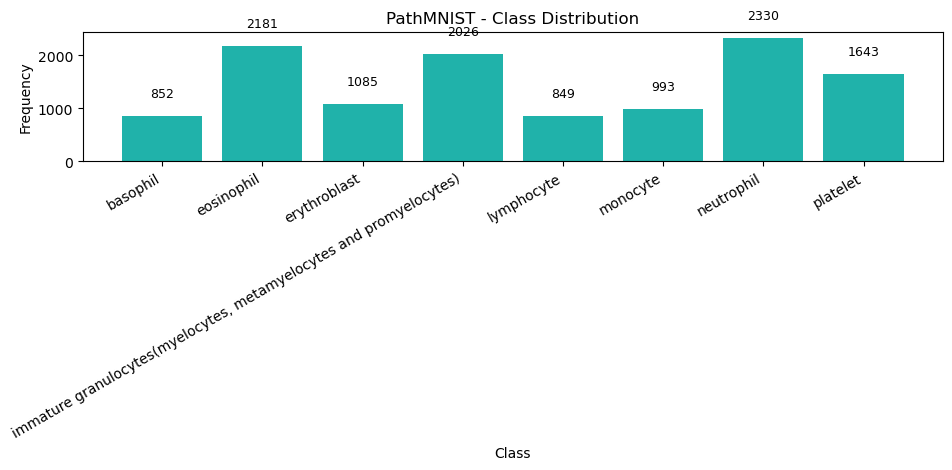

In [7]:
# Checking class distribution

info = INFO["bloodmnist"]
class_names = {int(k): v for k, v in info["label"].items()}  # converted keys to int

dist = get_class_distribution(train_loader)
print("Frequency per class:", dict(dist))
plot_class_distribution(dist, class_names=class_names)

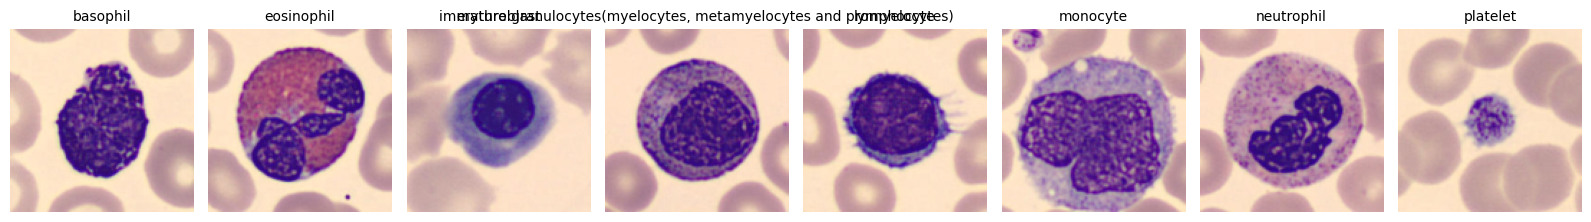

In [8]:
# Single row with one sample from each class
visualize_one_sample_per_class_single_row(train_loader, class_names=class_names)

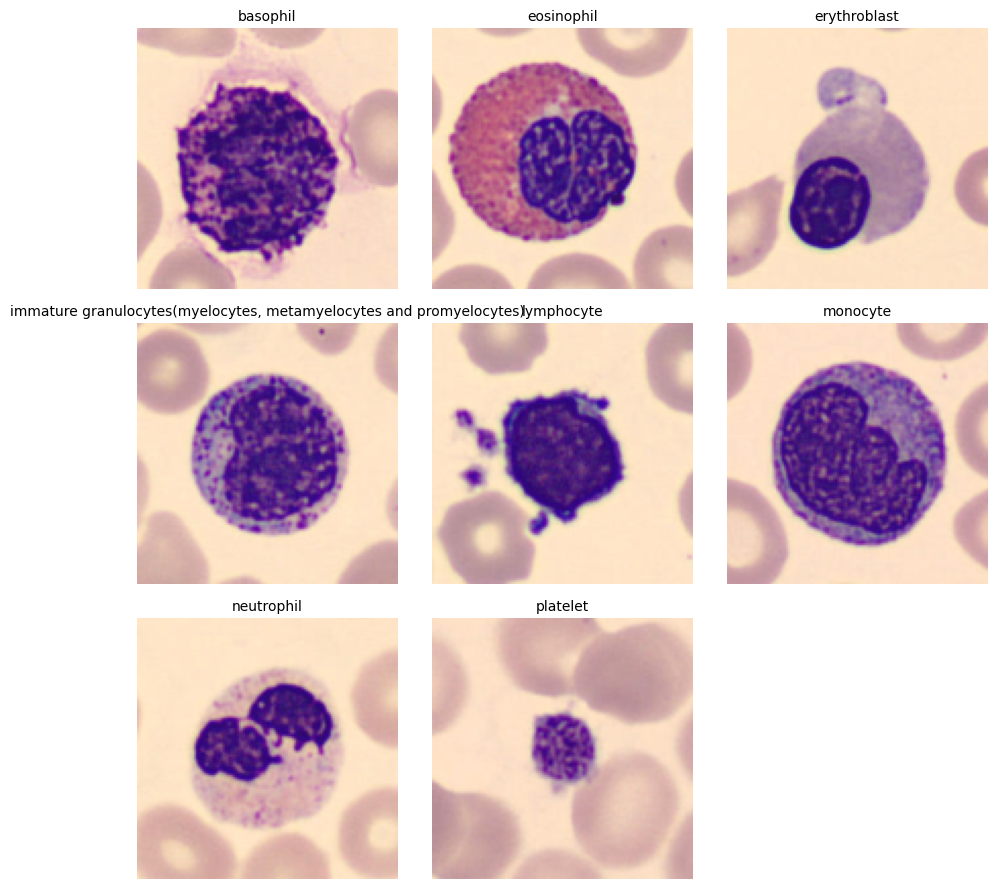

In [9]:
# See a sample from each class
visualize_one_sample_per_class(train_loader, class_names=class_names)

### Occlusion tests

#### Functions

In [10]:
def get_occlusion_result(img, label, x, y, patch_size):
    """
    Applies grey square occlusion and returns relevant values.
    """
    occluded = img.clone()                                # copy input image
    occluded[:, :, y:y+patch_size, x:x+patch_size] = 0.5  # apply the grey square

    with torch.no_grad():
        logits_occ, acts_occ = alexnet(occluded)                  # forward pass the occluded img through the model
        feat5_occ = acts_occ["feat5"]                             # extract feature map activations from layer 5
        prob_occ = F.softmax(logits_occ, dim=1)[0, label].item()  # compute probability of true class with softmax
        pred_class = logits_occ.argmax(dim=1).item()              # get the predicted class
        # compute the total activation of the strongest feature map in layer 5
        activation = feat5_occ[0, strongest_idx].sum().item()    

    # Return:
    # the occluded image (converted to shape [3, H, W] and moved to CPU)
    # the total activation value of the strongest feature
    # the probability of the true class
    # the predicted class index
    return occluded.squeeze().cpu(), activation, prob_occ, pred_class

In [11]:
def generate_occlusion_maps(img, label, patch_size=64, stride=10):
    H, W = img.shape[2:]
    xs = list(range(0, W - patch_size + 1, stride))
    ys = list(range(0, H - patch_size + 1, stride))

    activation_map = np.zeros((len(ys), len(xs)))
    prob_map = np.zeros((len(ys), len(xs)))
    pred_map = np.zeros((len(ys), len(xs)), dtype=int)

    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            _, act, prob, pred = get_occlusion_result(img, label, x, y, patch_size)
            activation_map[i, j] = act
            prob_map[i, j] = prob
            pred_map[i, j] = pred

    return activation_map, prob_map, pred_map,xs, ys

In [12]:
def plot_occlusion_entry(occluded_img, activation_map, prob_map, pred_map, pred_class, recon_np, x, y, xs, ys, file_name="occlusion.pdf"):

    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    axs[0].imshow(to_pil_image(occluded_img))
    axs[0].set_title(f"(a) Patch at ({x},{y})")
    axs[0].axis("off")

    # im1 = axs[1].imshow(activation_map, cmap="hot", extent=[xs[0], xs[-1]+1, ys[-1]+1, ys[0]])
    axs[1].imshow(activation_map, cmap="hot", extent=[xs[0], xs[-1]+1, ys[-1]+1, ys[0]])
    axs[1].set_title("(b) Layer 5 activation map")
    # fig.colorbar(im1, ax=axs[1])

    axs[2].imshow(recon_np)
    axs[2].set_title(f"(c) Feature projection")
    axs[2].axis("off")


    im2 = axs[3].imshow(prob_map, cmap="coolwarm", vmin=0, vmax=1, extent=[xs[0], xs[-1]+1, ys[-1]+1, ys[0]])
    axs[3].set_title(f"(d) P(true class)")
    fig.colorbar(im2, ax=axs[3])
    

    pred_name = class_names.get(pred_class, str(pred_class))
    axs[4].imshow(pred_map, cmap="tab20", extent=[xs[0], xs[-1]+1, ys[-1]+1, ys[0]])
    axs[4].set_title(f"(e) Predicted class:\n{pred_name}")
    axs[4].axis("off")

    fig.savefig(file_name, format="pdf", bbox_inches="tight")
    plt.tight_layout()
    plt.show()


#### Tests

Random image selected.
True label index: 6
True label name: neutrophil


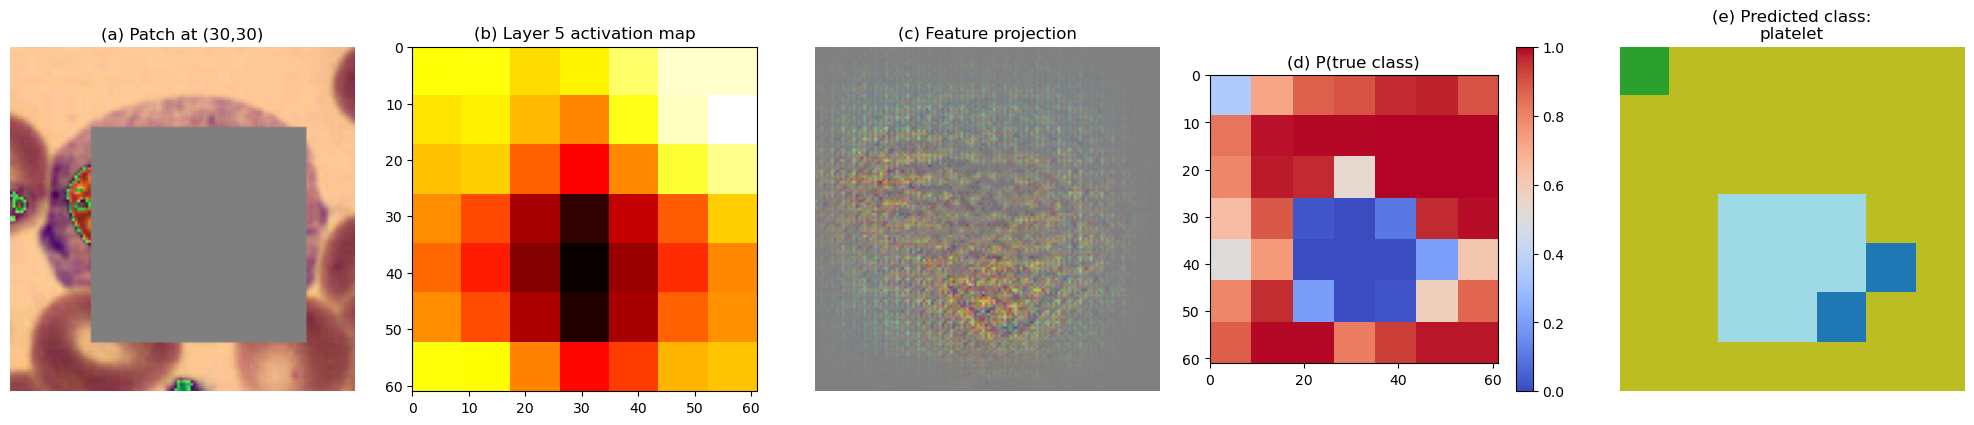

In [13]:
# Get a random image from a random batch in the test set
batch = next(iter(test_loader))
rand_idx = random.randint(0, len(batch[0]) - 1)
img, label = batch[0][rand_idx], batch[1][rand_idx]
img = img.unsqueeze(0).to(device)
label = label.item()

print("Random image selected.")
print("True label index:", label)
print("True label name:", class_names[label])

# Forward pass through model to get original activations
alexnet.eval()
with torch.no_grad():
    logits, acts = alexnet(img)

# Get strongest feature map in layer 5
feat5 = acts["feat5"]
strongest_idx = feat5[0].sum(dim=(1, 2)).argmax().item()

# Prepare one-hot map to project back the strongest feature
# one_hot = torch.zeros_like(feat5)
# one_hot[0, strongest_idx] = feat5[0, strongest_idx]

feat_pos = torch.clamp(feat5, min=0.0)

# Get the projected feature visualization using deconvnet
with torch.no_grad():
    # recon = deconvnet(one_hot, acts, layer=5)
    recon    = deconvnet(feat_pos, acts, layer=5)
recon_np = recon.squeeze().cpu().permute(1, 2, 0).numpy()
recon_np = (recon_np - recon_np.min()) / (recon_np.max() - recon_np.min())


# Generate heatmaps
activation_map, prob_map, pred_map, xs, ys = generate_occlusion_maps(img, label, patch_size=64, stride=10)


# Use occlusion 
x, y = xs[len(xs)//2], ys[len(ys)//2]
occ_img, _, _, pred = get_occlusion_result(img, label, x, y, patch_size=80)

# Plot
plot_occlusion_entry(occ_img, activation_map, prob_map, pred_map, pred, recon_np, x, y, xs, ys)


Random image selected.
True label index: 7
True label name: platelet


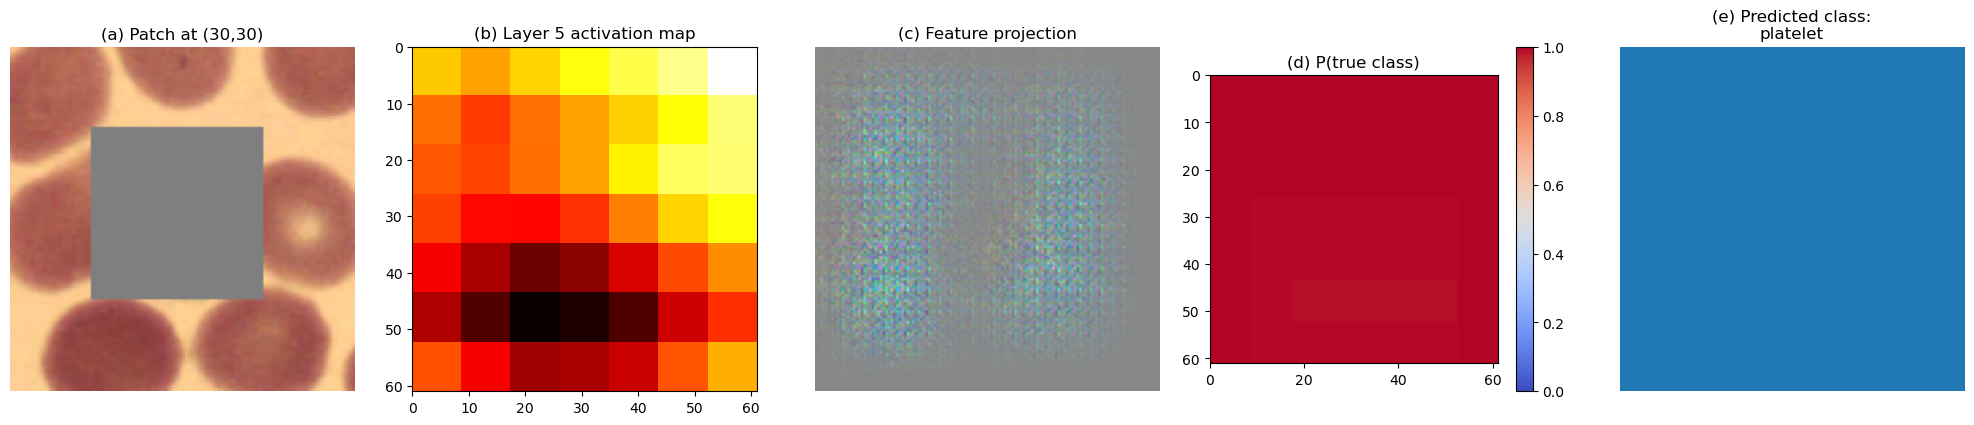

In [14]:
# Get a random image from a random batch in the test set
batch = next(iter(test_loader))
rand_idx = random.randint(0, len(batch[0]) - 1)
img, label = batch[0][rand_idx], batch[1][rand_idx]
img = img.unsqueeze(0).to(device)
label = label.item()

print("Random image selected.")
print("True label index:", label)
print("True label name:", class_names[label])

# Forward pass through model to get original activations
alexnet.eval()
with torch.no_grad():
    logits, acts = alexnet(img)

# Get strongest feature map in layer 5
feat5 = acts["feat5"]
strongest_idx = feat5[0].sum(dim=(1, 2)).argmax().item()

# Prepare one-hot map to project back the strongest feature
one_hot = torch.zeros_like(feat5)
one_hot[0, strongest_idx] = feat5[0, strongest_idx]

# Get the projected feature visualization using deconvnet
with torch.no_grad():
    recon = deconvnet(one_hot, acts, layer=5)
recon_np = recon.squeeze().cpu().permute(1, 2, 0).numpy()
recon_np = (recon_np - recon_np.min()) / (recon_np.max() - recon_np.min())


# Generate heatmaps
activation_map, prob_map, pred_map, xs, ys = generate_occlusion_maps(img, label, patch_size=64, stride=10)


# Use occlusion 
x, y = xs[len(xs)//2], ys[len(ys)//2]
occ_img, _, _, pred = get_occlusion_result(img, label, x, y, patch_size=64)

# Plot
plot_occlusion_entry(occ_img, activation_map, prob_map, pred_map, pred, recon_np, x, y, xs, ys)


Random image selected.
True label index: 1
True label name: eosinophil


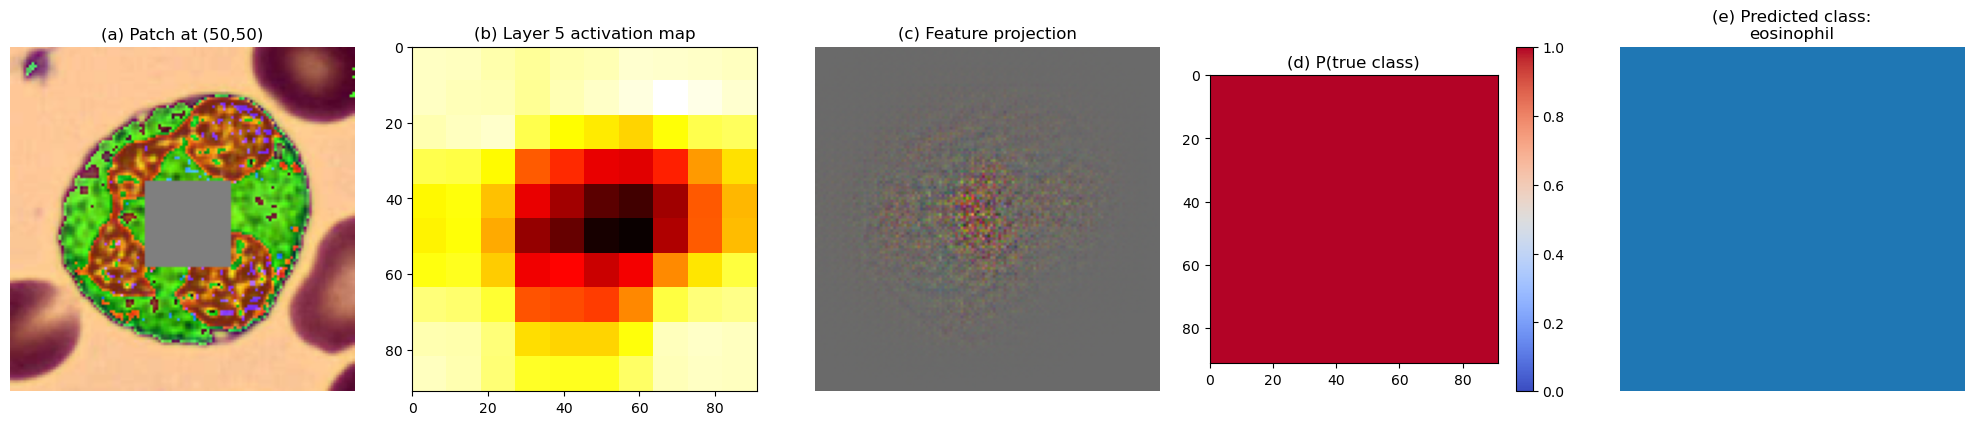

In [15]:
# Get a random image from a random batch in the test set
batch = next(iter(test_loader))
rand_idx = random.randint(0, len(batch[0]) - 1)
img, label = batch[0][rand_idx], batch[1][rand_idx]
img = img.unsqueeze(0).to(device)
label = label.item()

print("Random image selected.")
print("True label index:", label)
print("True label name:", class_names[label])

# Forward pass through model to get original activations
alexnet.eval()
with torch.no_grad():
    logits, acts = alexnet(img)

# Get strongest feature map in layer 5
feat5 = acts["feat5"]
strongest_idx = feat5[0].sum(dim=(1, 2)).argmax().item()

# Prepare one-hot map to project back the strongest feature
one_hot = torch.zeros_like(feat5)
one_hot[0, strongest_idx] = feat5[0, strongest_idx]

# Get the projected feature visualization using deconvnet
with torch.no_grad():
    recon = deconvnet(one_hot, acts, layer=5)
recon_np = recon.squeeze().cpu().permute(1, 2, 0).numpy()
recon_np = (recon_np - recon_np.min()) / (recon_np.max() - recon_np.min())


# Generate heatmaps
activation_map, prob_map, pred_map, xs, ys = generate_occlusion_maps(img, label, patch_size=32, stride=10)


# Use occlusion 
x, y = xs[len(xs)//2], ys[len(ys)//2]
occ_img, _, _, pred = get_occlusion_result(img, label, x, y, patch_size=32)

# Plot
plot_occlusion_entry(occ_img, activation_map, prob_map, pred_map, pred, recon_np, x, y, xs, ys)


Random image selected.
True label index: 1
True label name: eosinophil


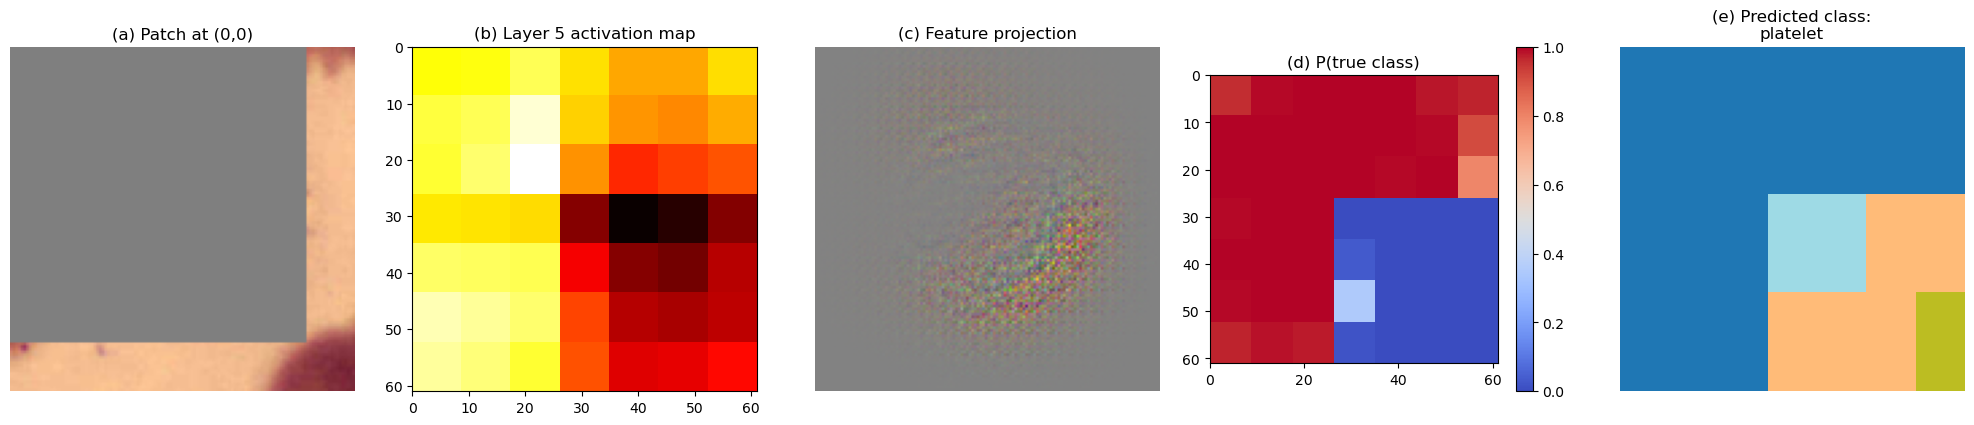

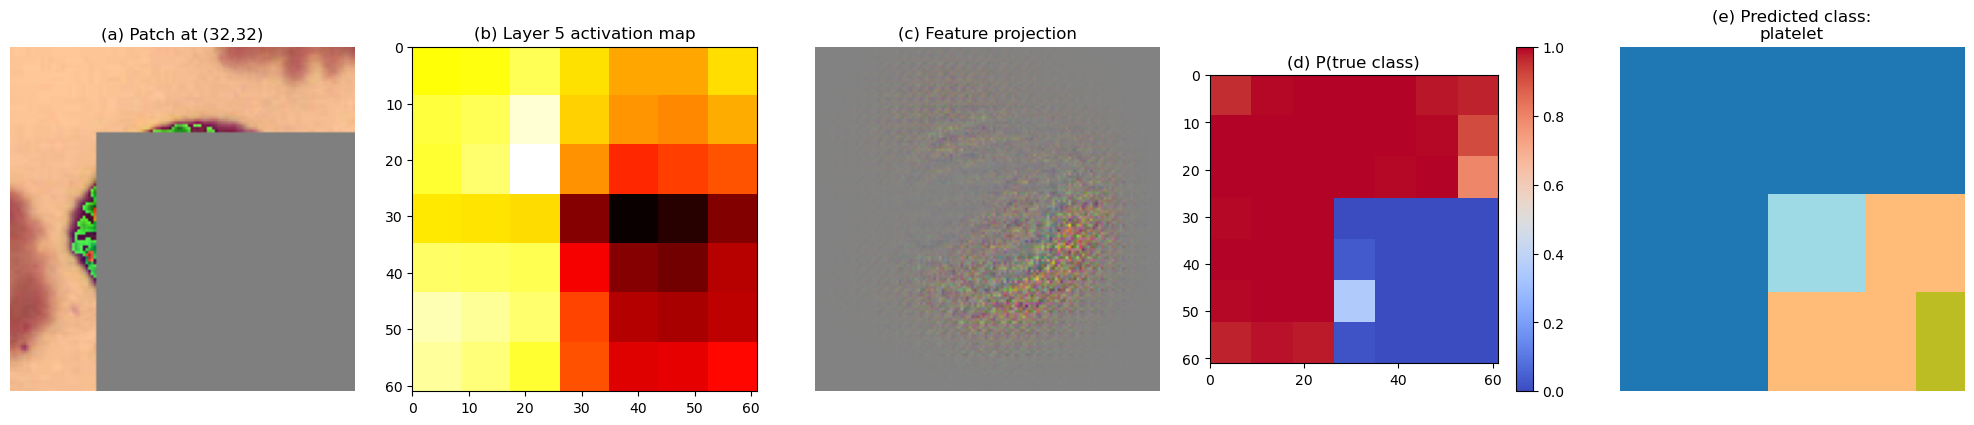

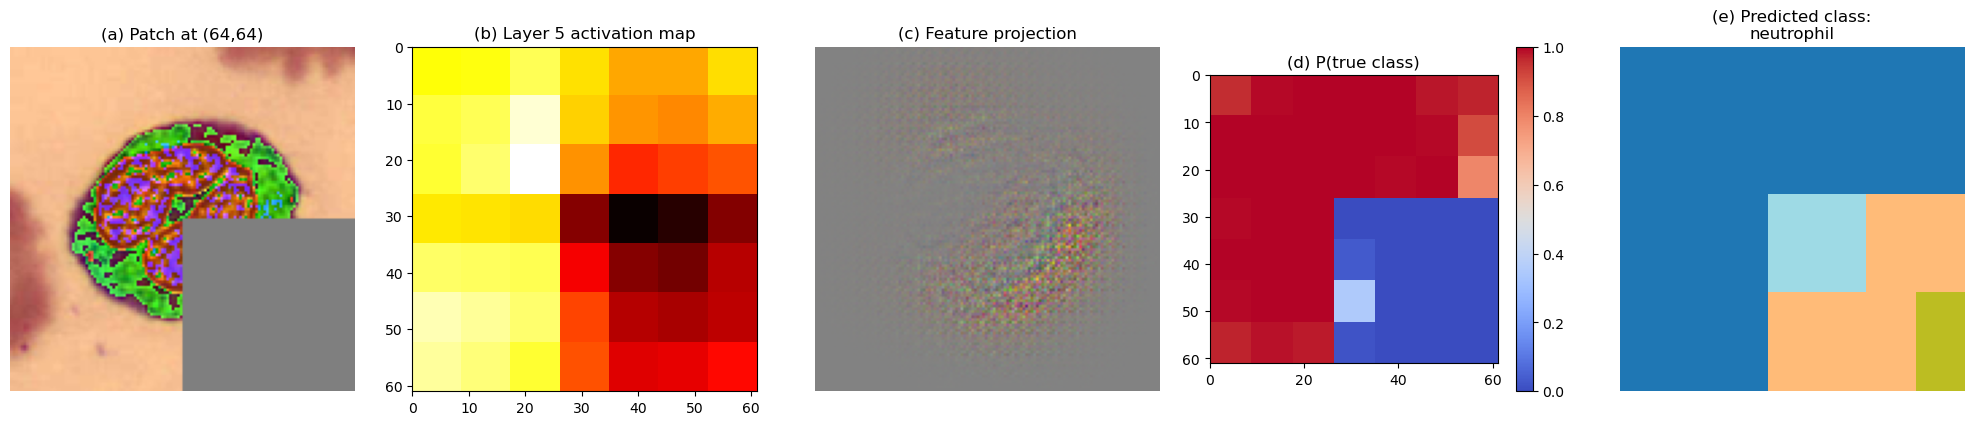

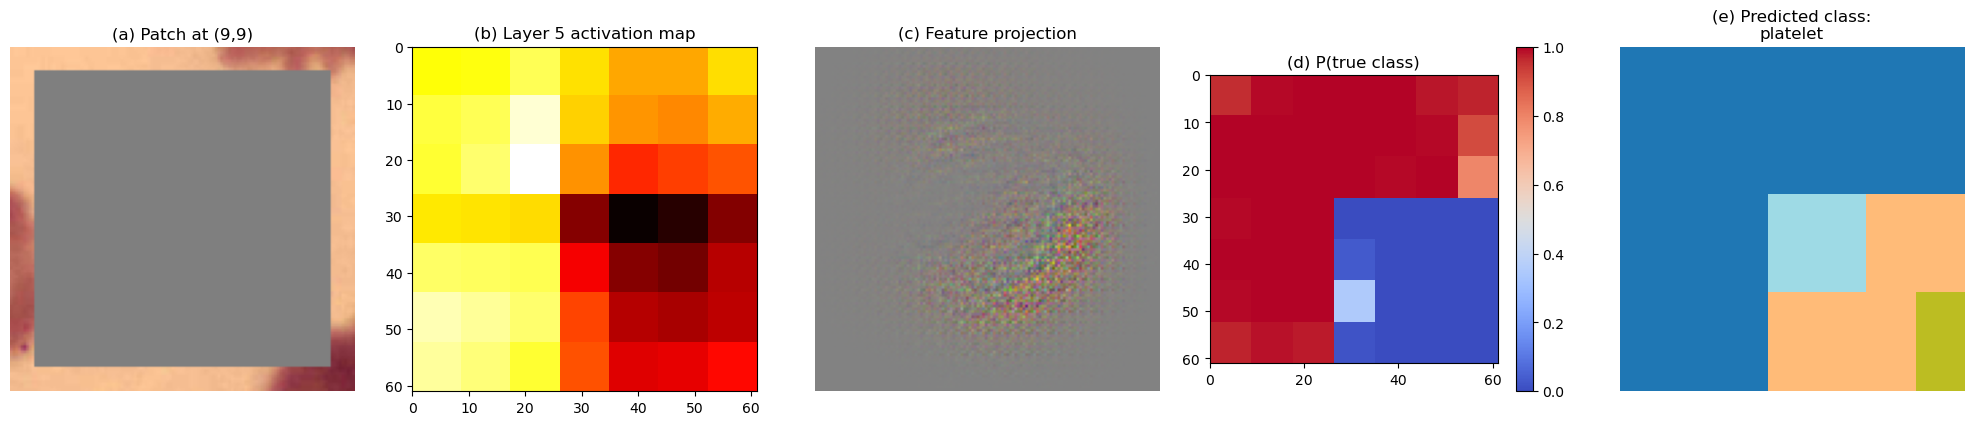

In [16]:
# Get a random image from a random batch in the test set
batch = next(iter(test_loader))
rand_idx = random.randint(0, len(batch[0]) - 1)
img, label = batch[0][rand_idx], batch[1][rand_idx]
img = img.unsqueeze(0).to(device)
label = label.item()

print("Random image selected.")
print("True label index:", label)
print("True label name:", class_names[label])

# Forward pass through model to get original activations
alexnet.eval()
with torch.no_grad():
    logits, acts = alexnet(img)

# Get strongest feature map in layer 5
feat5 = acts["feat5"]
strongest_idx = feat5[0].sum(dim=(1, 2)).argmax().item()

# Prepare one-hot map to project back the strongest feature
one_hot = torch.zeros_like(feat5)
one_hot[0, strongest_idx] = feat5[0, strongest_idx]

# Get the projected feature visualization using deconvnet
with torch.no_grad():
    recon = deconvnet(one_hot, acts, layer=5)
recon_np = recon.squeeze().cpu().permute(1, 2, 0).numpy()
recon_np = (recon_np - recon_np.min()) / (recon_np.max() - recon_np.min())


# Generate heatmaps
#activation_map, prob_map, pred_map, xs, ys = generate_occlusion_maps(img, label, patch_size=20, stride=10)

# Define patch size and occlusion positions
patch_size = 110
center_x = (128 - patch_size) // 2
center_y = (128 - patch_size) // 2
positions = [(0, 0), (32, 32), (64, 64), (center_x, center_y)]

# Generate the maps for this occluded version    
activation_map, prob_map, pred_map, xs, ys = generate_occlusion_maps(img, label, patch_size=64, stride=10)

# Loop through occlusion positions and plot results
for (x, y) in positions:
    occ_img, _, _, pred = get_occlusion_result(img, label, x, y, patch_size=patch_size)

    # plot_occlusion_entry(occ_img, activation_map, prob_map, pred_map, recon_np, x, y, xs, ys)
    plot_occlusion_entry(occ_img, activation_map, prob_map, pred_map, pred, recon_np, x, y, xs, ys)

